# Apply CWT to the FHR signals according to Daydulo et al. 2022

[Daydulo et al. 2022](https://doi.org/10.1186/s12911-022-02068-1) - Deep learning based fetal distress detection from time frequency representation of cardiotocogram signal using Morse wavelet: research study.

Open Access This article is licensed under a Creative Commons Attribution 4.0 International License, which permits use, sharing, adaptation, distribution and reproduction in any medium or format, as long as you give appropriate credit to the original author(s) and the source, provide a link to the Creative Commons licence, and indicate if changes were made. The images or other third party material in this article are included in the article's Creative Commons licence, unless indicated otherwise in a credit line to the material. If material is not included in the article's Creative Commons licence and your intended use is not permitted by statutory regulation or exceeds the permitted use, you will need to obtain permission directly from the copyright holder. To view a copy of this licence, visit http://creativecommons.org/licenses/by/4.0/. The Creative Commons Public Domain Dedication waiver (http://creativecommons.org/publicdomain/zero/1.0/) applies to the data made available in this article, unless otherwise stated in a credit line to the data. Reprints and Permissions

## Set up

In [1]:
from dataclasses import dataclass
from IPython.display import Image
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
from scipy import signal
from ssqueezepy import Wavelet, cwt
from ssqueezepy.utils import make_scales, cwt_scalebounds
from ssqueezepy.visuals import imshow

In [2]:
# Define file paths
@dataclass(frozen=True)
class Paths:
    '''Singleton object for storing paths to data and database.'''

    data = './data_csv'
    meta = 'metadata.csv'
    images = './outputs/daydulo_scaleograms'


paths = Paths()

In [3]:
# Set up dictionary for CSV files
csv_files = dict()

# Load files into dictionary, but remove metadata
filenames = os.listdir(paths.data)
filenames.remove(paths.meta)
for file in filenames:
    # Get filename and file extension
    filename, file_extension = os.path.splitext(os.path.join(paths.data, file))
    # Load data and save to dict with filename (without path/csv) as index
    if file_extension == '.csv':
        filename_short = filename.split('/')[-1]
        csv_files[filename_short] = pd.read_csv(os.path.join(paths.data, file))

# Load meta data and transform
metadata = pd.read_csv('./data_csv/metadata.csv', index_col='parameter')
csv_index = list(metadata)

## Signal pre-processing

Signal pre-processing:
* Long gaps (more than 15s) removed from the signal
* Missing values at beginning and end of recording excluded to start from the stable point
* Outside 50bpm or 200bpm are outliers
* Outliers and small gaps were find and linearly interpolated using Matlab
* Spikes are when beat is more than 25 from previous adjacent beat (not physiologic, unreliable) so removed using cubic spline interpolation.

Selected segment of the first 20 minutes (4800) and last 15 minutes (3600) to use and represent first and second stage of labour.

In [4]:
def daydulo_clean(fhr):
    '''
    Cleans fetal heart rate (FHR) signal according to Daydulo et al. 2022
    Inputs:
    fhr - series, the "FHR" column from one of the csv files
    '''

    # Replace 0 with NaN
    fhr.replace(0, np.nan, inplace=True)

    # Remove NaN if they occured for more than 15 seconds consecutively
    na = fhr.isnull()
    fhr = fhr[~(fhr.groupby(na.ne(na.shift()).cumsum().values).transform('size').ge(61) & na)].reset_index(drop=True)

    # Set outliers to NaN
    fhr[fhr < 50] = np.nan
    fhr[fhr > 200] = np.nan

    # Replace missing values using linear interpolation
    fhr = fhr.interpolate(method='linear')

    # Find how each value has changed from the prior value
    diff = fhr - fhr.shift()

    # Where difference is more than +- 25, set as NaN
    fhr[(diff > 25) | (diff < -25)] = np.nan

    # Replace missing values using cubic interpolation
    fhr = fhr.interpolate(method='cubic')

    return(fhr)

In [5]:
# Loop through all the csv file dataframes, apply cleaning, then save
# the segments into two dictionaries 
fhr_first = dict()
fhr_second = dict()
for key, value in csv_files.items():
    df = daydulo_clean(value.FHR)
    fhr_first[key] = df.head(4800)
    fhr_second[key] = df.tail(3600).reset_index(drop=True)

Plot example from Daydulo -

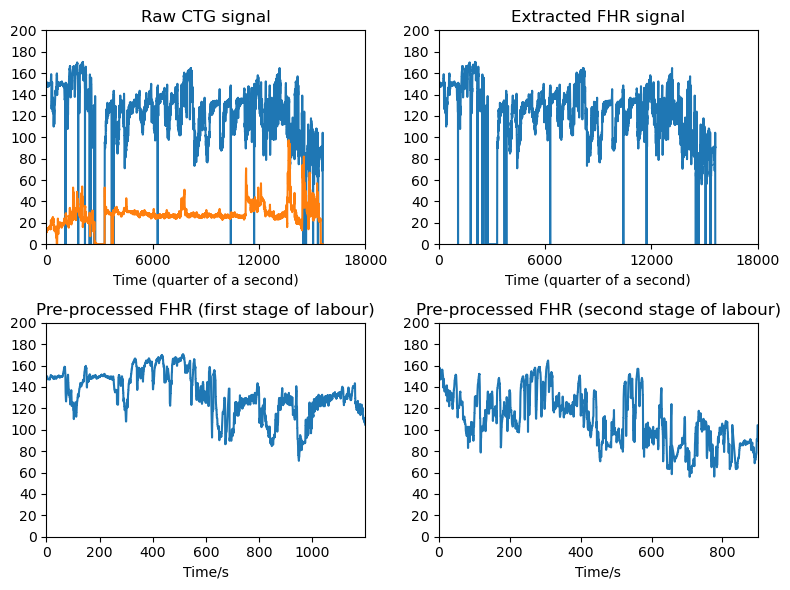

In [6]:
# Initialise plot
fig, ax = plt.subplots(ncols=2, nrows=2, figsize=(8, 6))

# Plot raw FHR and UC
ax[0,0].plot(csv_files['1011'].FHR.fillna(0))
ax[0,0].plot(csv_files['1011'].UC.fillna(0))
ax[0,0].margins(x=0)
ax[0,0].set_ylim(0, 200)
ax[0,0].set_xlabel('Time (quarter of a second)')
ax[0,0].set_title('Raw CTG signal')
ax[0,0].set_xticks([0, 6000, 12000, 18000])
ax[0,0].set_yticks(np.arange(0, 201, 20))

# Plot raw FHR
ax[0,1].plot(csv_files['1011'].FHR.fillna(0))
ax[0,1].margins(x=0)
ax[0,1].set_ylim(0, 200)
ax[0,1].set_xlabel('Time (quarter of a second)')
ax[0,1].set_title('Extracted FHR signal')
ax[0,1].set_xticks([0, 6000, 12000, 18000])
ax[0,1].set_yticks(np.arange(0, 201, 20))

# Plot clean FHR stage 1
ax[1,0].plot(fhr_first['1011'].index/4, fhr_first['1011'])
ax[1,0].margins(x=0)
ax[1,0].set_ylim(0, 200)
ax[1,0].set_xlabel('Time/s')
ax[1,0].set_title('Pre-processed FHR (first stage of labour)')
ax[1,0].set_yticks(np.arange(0, 201, 20))

# Plot clean FHR stage 2
ax[1,1].plot(fhr_second['1011'].index/4, fhr_second['1011'])
ax[1,1].margins(x=0)
ax[1,1].set_ylim(0, 200)
ax[1,1].set_xlabel('Time/s')
ax[1,1].set_title('Pre-processed FHR (second stage of labour)')
ax[1,1].set_yticks(np.arange(0, 201, 20))

plt.tight_layout()
plt.show()

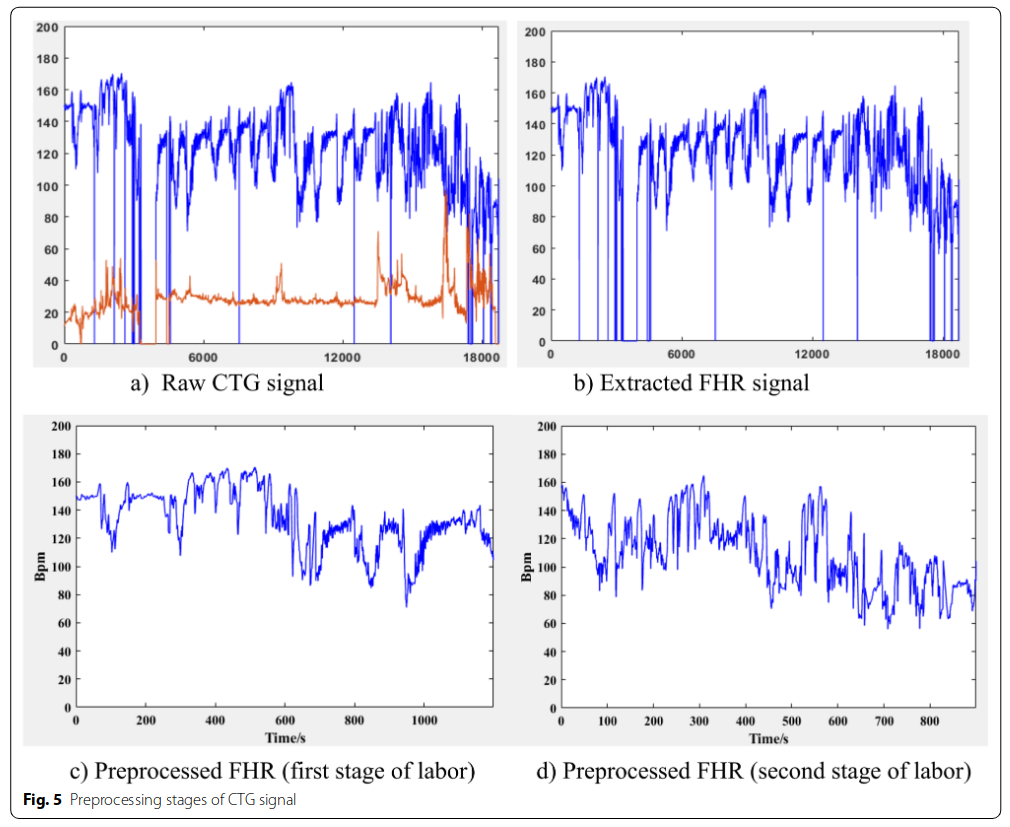

In [7]:
Image('images/daydulo_figure5.png')

## Data augmentation

### Explanation

pH <= 7.15 as pathological and pH > 7.15 as normal. This created 439 normal and 113 for distressed.

Slicing augmentation (same as image cropping augmentation). Augment data by removing or adding time steps to pattern ends. They oversample the minority class by slicing shifting backward for five minute two times. Therefore, slice of 20-min window slide for first stage and 15-min window slice for second labor stage were generated.

After augmentation final dataset contained 1556 time frequency images of which:
* 878 is for normal class
* 678 for pathologic or distressed class. 

In [8]:
# Designate class to each record
ph = metadata[metadata.index == 'pH'].T
ph['class'] = np.where(ph['pH'] <= 7.15, 1, 0)
ph['class'].value_counts()

class
0    439
1    113
Name: count, dtype: int64

These are the number of records in each class. We take a segment from the start and end, and so the total normal class size is double that - 878.

In [9]:
878/2

439.0

The distressed class has 113 records - or 226 after taking the two segments.

Augmentation means we have 3 versions of each segment - the original version, and then two slices. Window slicing involves shifting the window of data that you extract, which they do by five minutes two times. I'm therefore assuming this to mean that we have something like this (these numbers if it's a full 90m record):
* First stage normal (0-20m)
* First stage shift one (5-25m)
* First stage shift two (10-30m)
* Second stage normal (70-90m)
* Second stage shift one (65-85m)
* Second stage shift two (60-80m)

In [10]:
113*6

678

### Application

Create dictionary that just contains data from the minority class

In [11]:
# Get list of ID in minority class and double-check length is correct
distress_records = ph[ph['class'] == 1].index.tolist()
len(distress_records)

113

In [12]:
# Filter dictionary to those ID, and double-check length is correct
csv_distress = dict((k, csv_files[k]) for k in distress_records)
len(csv_distress)

113

In [13]:
print(f'''
20 minutes is {4*60*20}, 5 minutes is {4*60*5}

First stage:
[0:4800] to get first 4800 items, so would
then be [1200:{4800+1200}], [2400:{4800+2400}]

Second stage:
Last 20 minutes is [-3600:], so would
then be [-{3600+1200}:-1200] and [-{3600+2400}:-2400]''')


20 minutes is 4800, 5 minutes is 1200

First stage:
[0:4800] to get first 4800 items, so would
then be [1200:6000], [2400:7200]

Second stage:
Last 20 minutes is [-3600:], so would
then be [-4800:-1200] and [-6000:-2400]


In [14]:
# Loop through those files, clean, and append the slices to the right dictionary
# With key name modified as _5 or _10 depending on the slice
for key, value in csv_distress.items():
    df = daydulo_clean(value.FHR)
    fhr_first[f'{key}_5'] = df[1200:6000]
    fhr_first[f'{key}_10'] = df[2400:7200]
    fhr_second[f'{key}_5'] = df[-4800:-1200]
    fhr_second[f'{key}_10'] = df[-6000:-2400]

Check example

In [15]:
csv_files['1447']

,quarter_second,FHR,UC,second,minute
0,0,NaN,0.0,0,0
1,1,NaN,0.0,0,0
2,2,NaN,0.0,0,0
3,3,NaN,0.0,0,0
4,4,NaN,0.0,1,0
...,...,...,...,...,...
17995,17995,NaN,0.0,4498,74
17996,17996,NaN,0.0,4499,74
17997,17997,NaN,0.0,4499,74
17998,17998,NaN,0.0,4499,74


In [16]:
fhr_first['1447_5']

1200    169.50
1201    170.75
1202    170.75
1203    171.25
1204    171.00
         ...  
5995    149.25
5996    149.50
5997    148.00
5998    148.00
5999    147.75
Name: FHR, Length: 4800, dtype: float64

In [17]:
fhr_first['1447_10']

2400    166.161765
2401    166.529412
2402    166.897059
2403    167.264706
2404    167.632353
           ...    
7195    133.000000
7196    134.250000
7197    134.250000
7198    133.750000
7199    133.750000
Name: FHR, Length: 4800, dtype: float64

In [22]:
len(fhr_first) + len(fhr_second)

1556

## CWT

* MATLAB
* Generalised Morse wavelet
* Gamma (γ) parameter = 3
* Time-bandwidth product (P<sup>2</sup>) = 60, 55 (figures use 5, 60, and 120) - ssqueezepy gmw accepts β. P<sup>2</sup> = βγ, so used values of -
    * 4 = β*3, so β=0.75
    * 60 = β*3, so β=20
    * 120 = β*3, so β=40
* Voice for octave value of 12

In [18]:
def daydulo_cwt(fhr, beta, p2, axes):
    '''
    Perform CWT and plot scaleogram for replicating Daydulo at given values
    of beta and p2
    - fhr: series, FHR signal
    - beta: number, decay/compactness parameter, relates to p2, used for CWT
    - p2: number, time-bandwidth product, just used to label the figure
    - axes: subplot number
    '''
    # Set parameters
    signal_length = len(fhr)
    wavelet = Wavelet(('gmw', {'gamma': 3, 'beta':beta}))
    voices_per_octave = 12

    # Find scales
    min_scale, max_scale = cwt_scalebounds(wavelet, signal_length)
    scales = make_scales(signal_length, scaletype='log', nv=voices_per_octave,
                        min_scale=min_scale, max_scale=max_scale)

    # Perform CWT
    Wx, _ = cwt(fhr, wavelet, scales=scales)

    # Visualise
    ax = fig.add_subplot(axes)
    imshow(data=Wx, abs=1, show=False, yticks=1/scales,
           title=f'FHR P2={p2}', xlabel='Time (quarter of a second)',
           ylabel='Frequency')

Replicate the figure

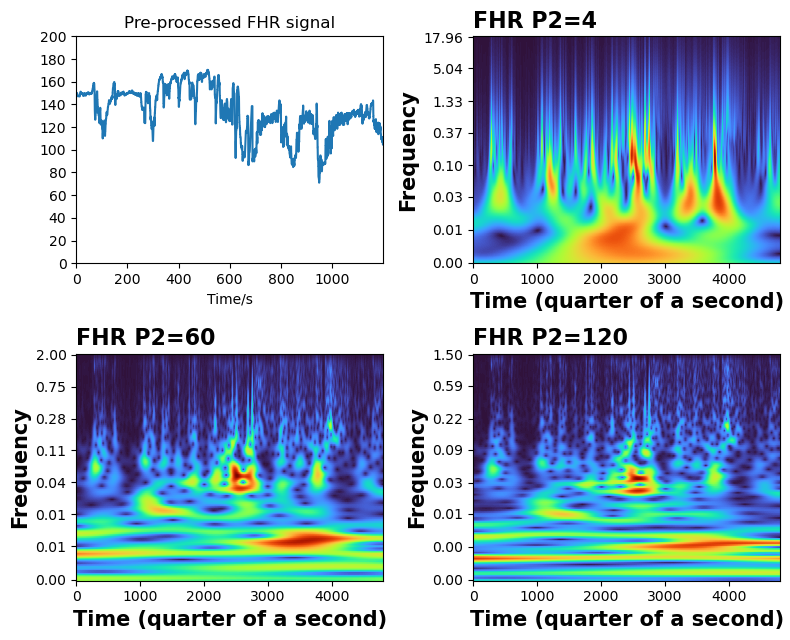

In [19]:
# Initialise plot
fig = plt.figure(figsize=(8, 6.5))

# Plot clean FHR stage 1
ax = fig.add_subplot(221)
ax.plot(fhr_first['1011'].index/4, fhr_first['1011'])
ax.margins(x=0)
ax.set_ylim(0, 200)
ax.set_xlabel('Time/s')
ax.set_title('Pre-processed FHR signal')
ax.set_yticks(np.arange(0, 201, 20))

# Plot CWT with different parameters
daydulo_cwt(fhr_first['1011'], beta=0.75, p2=4, axes=222)
daydulo_cwt(fhr_first['1011'], beta=20, p2=60, axes=223)
daydulo_cwt(fhr_first['1011'], beta=40, p2=120, axes=224)

plt.tight_layout()
plt.show()

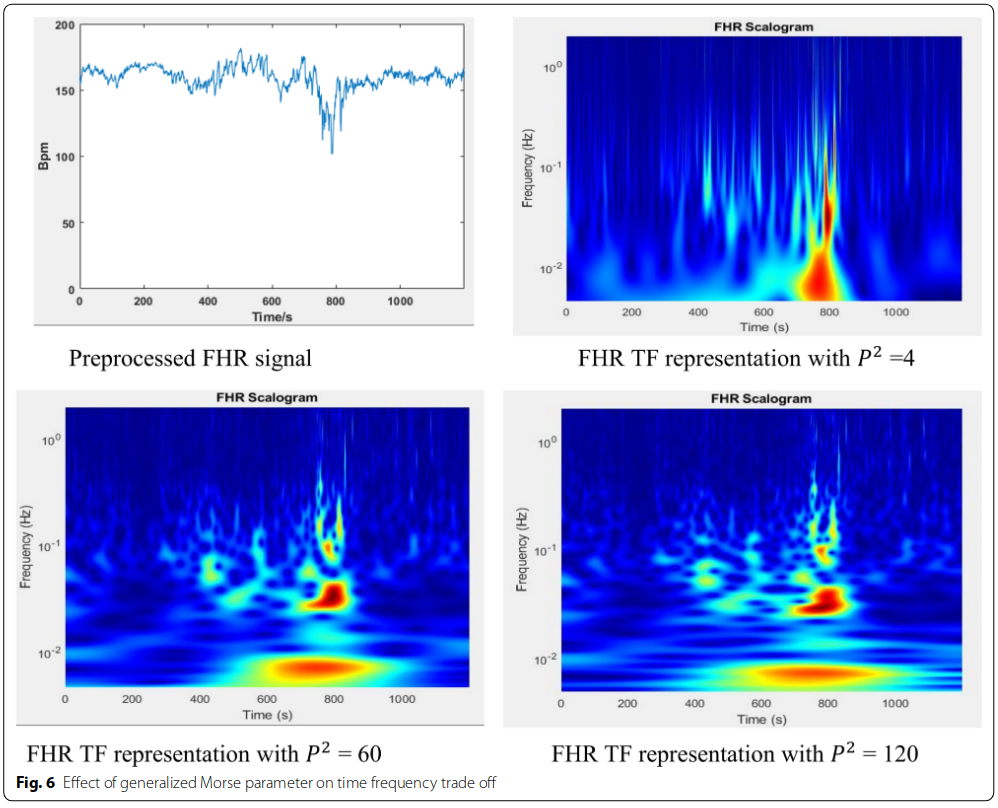

In [20]:
Image('images/daydulo_figure6.png')

In [21]:
#for key, value in signals.items():
#    fhr_scaleogram(record=key, scales=log_scale)

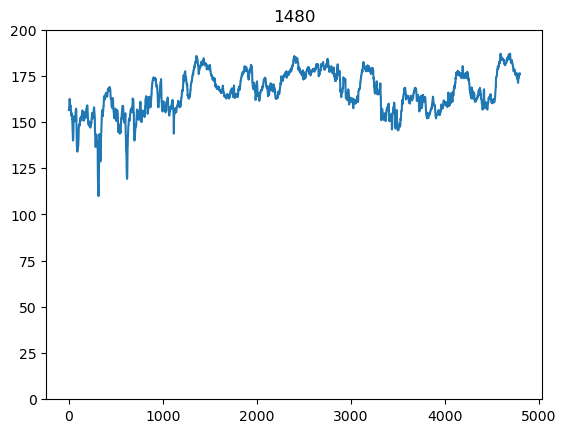

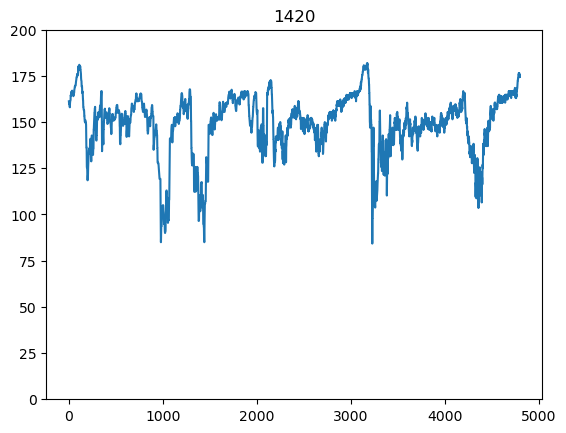

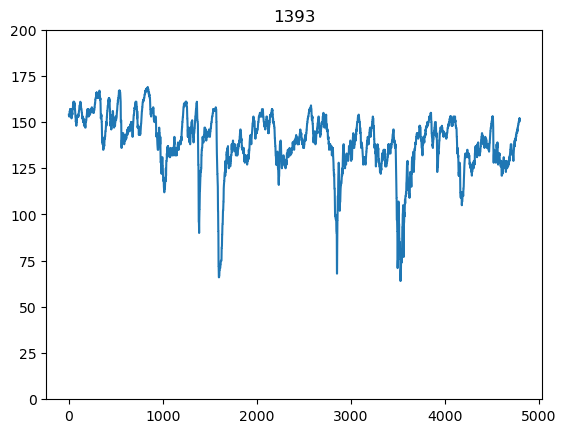

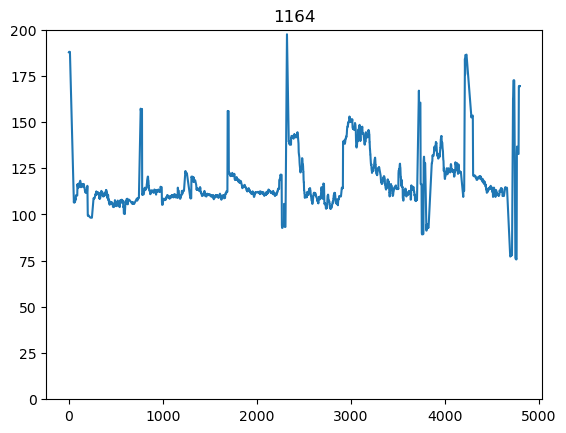

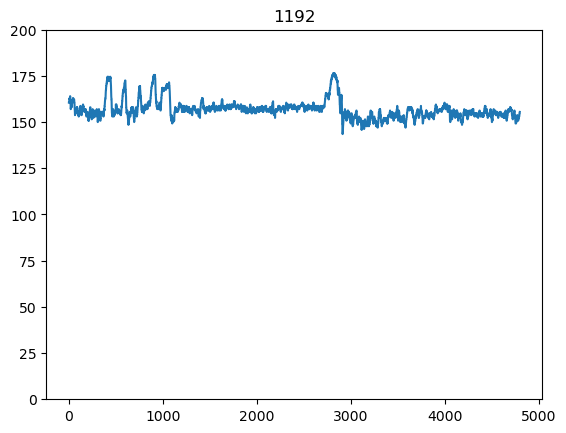

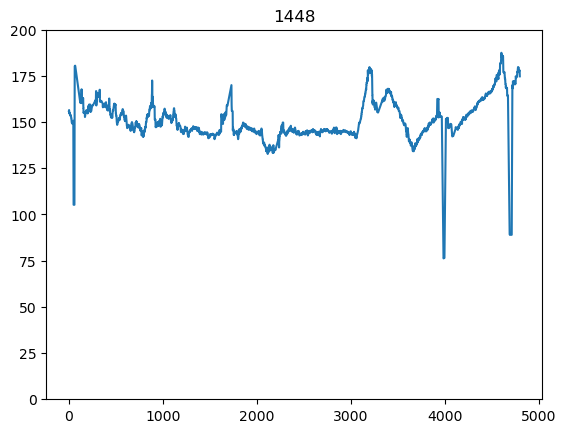

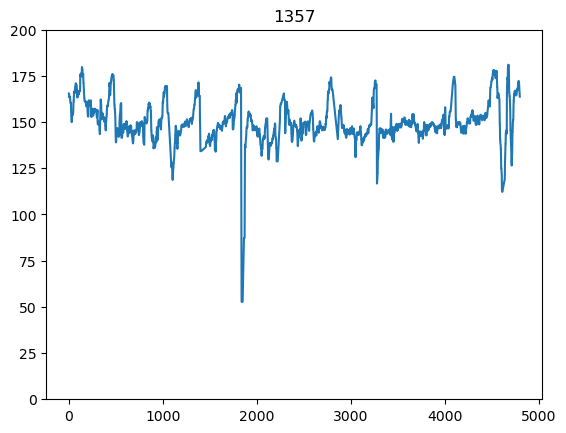

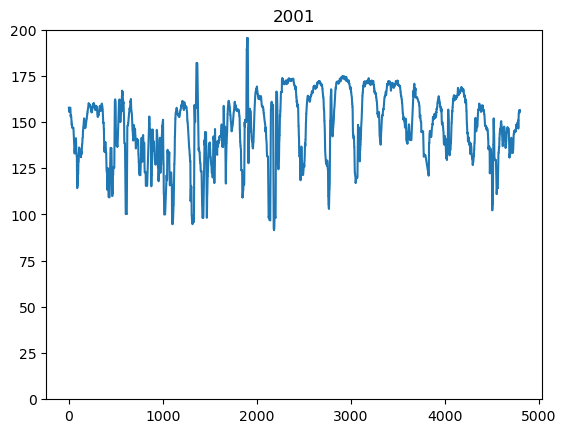

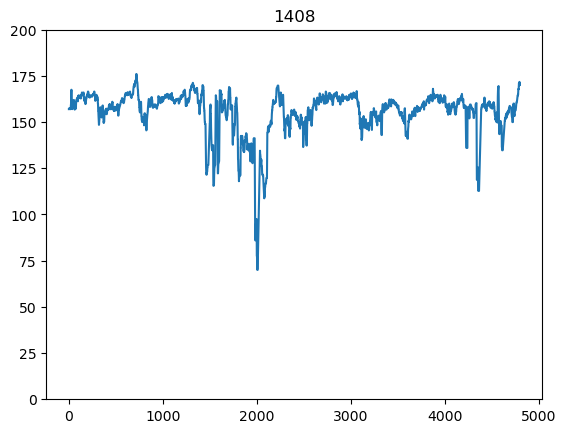

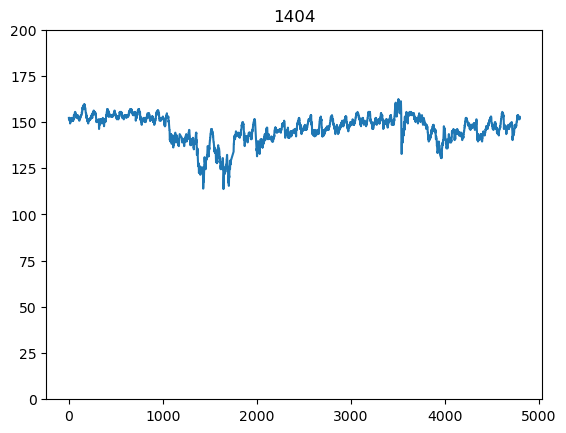

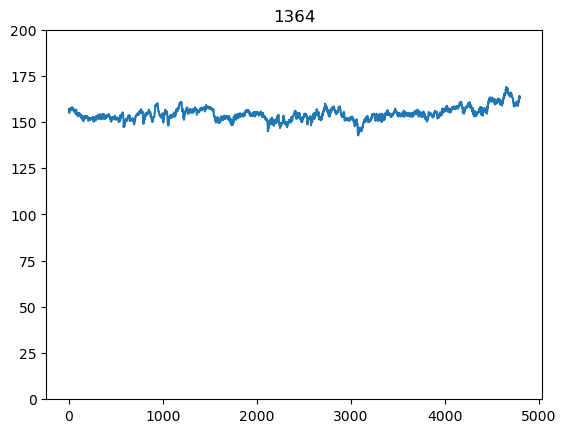

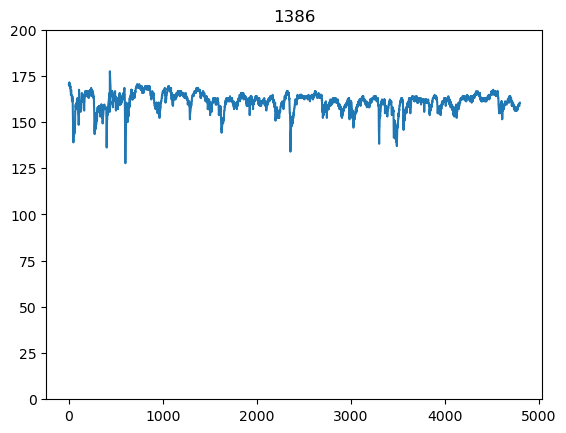

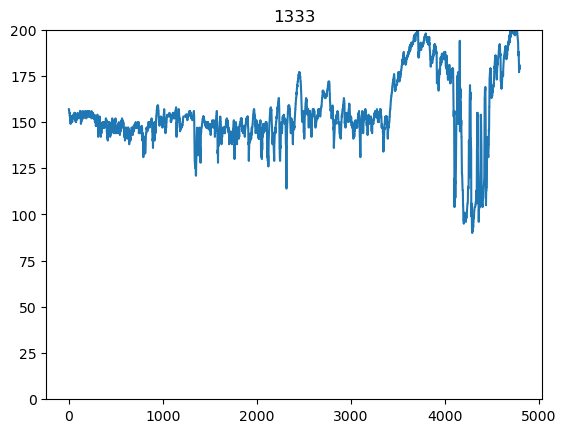

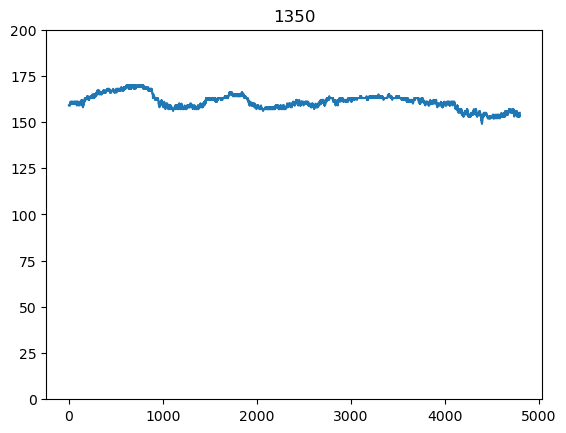

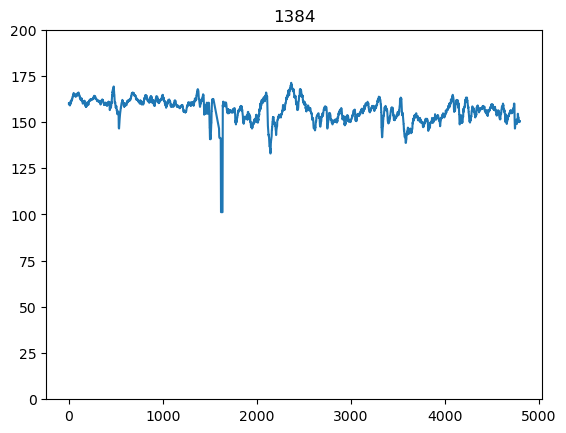

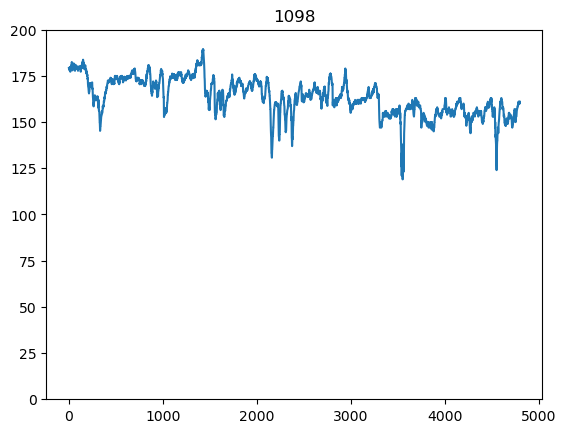

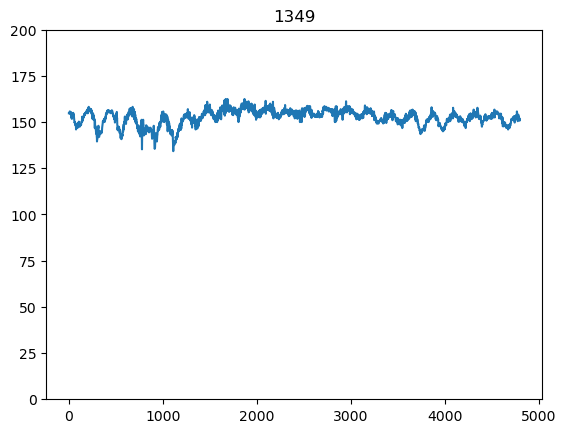

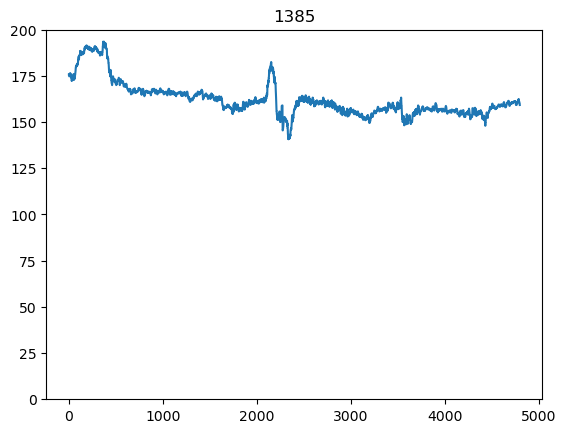

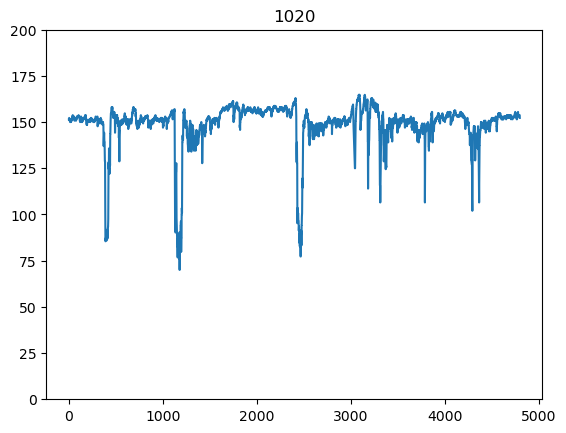

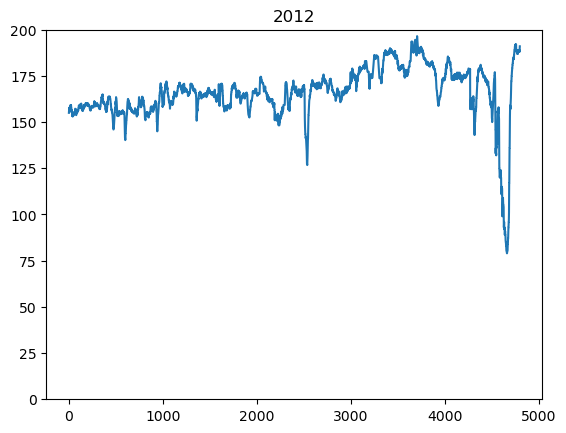

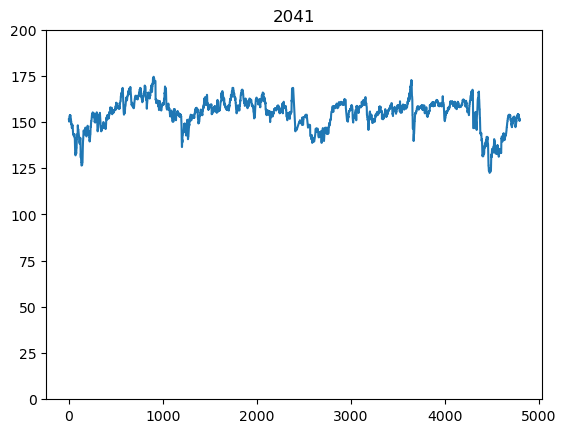

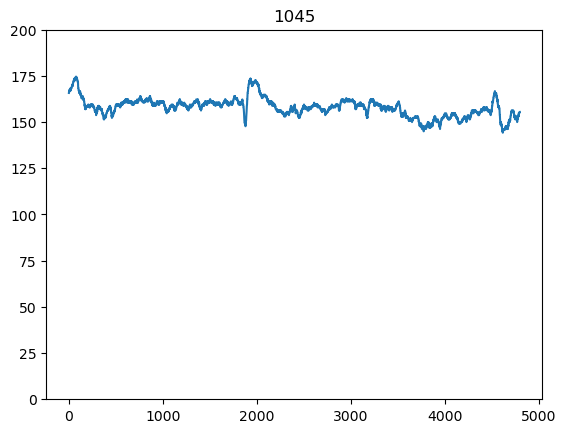

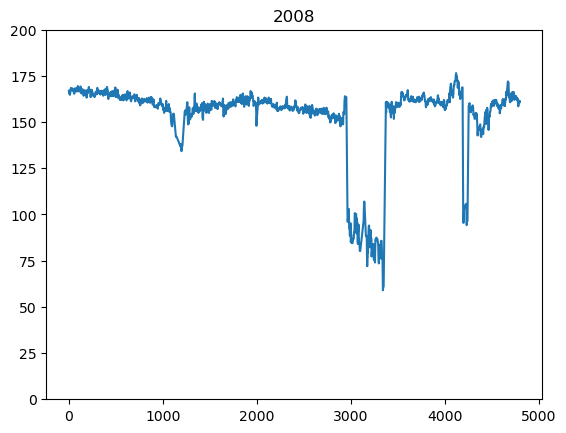

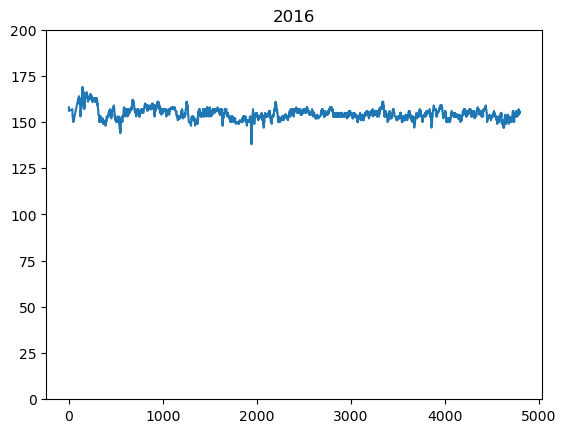

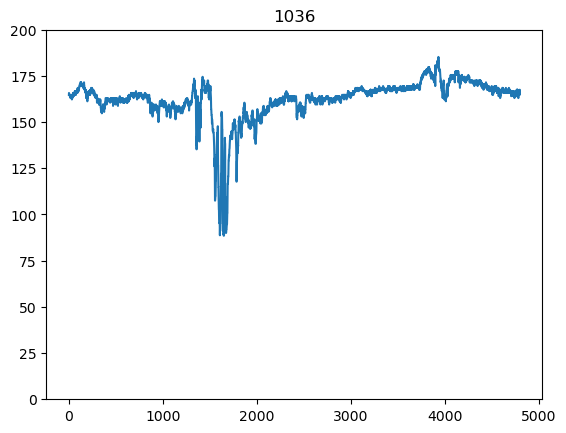

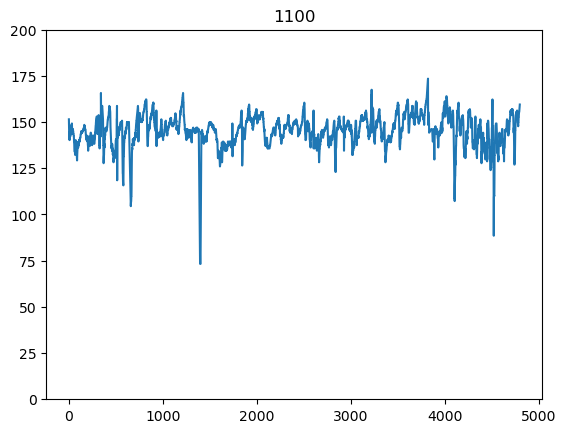

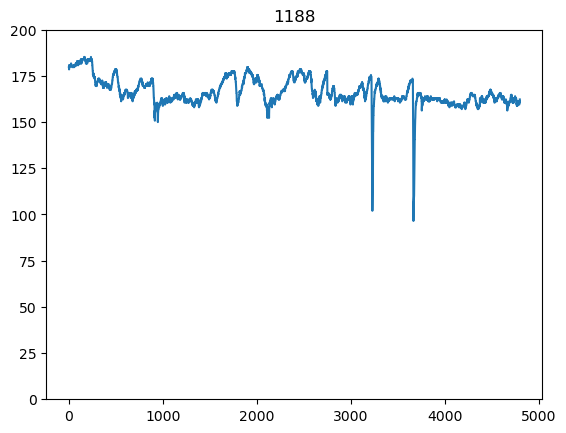

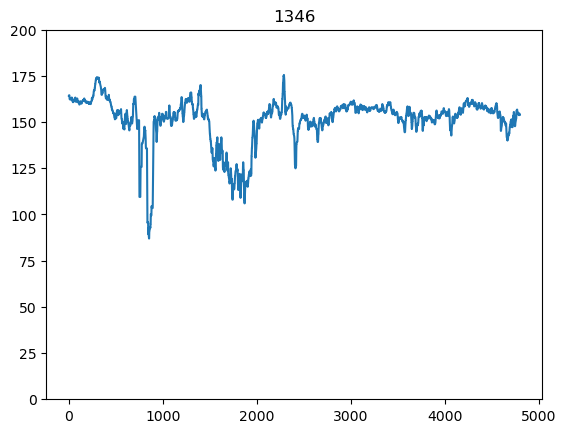

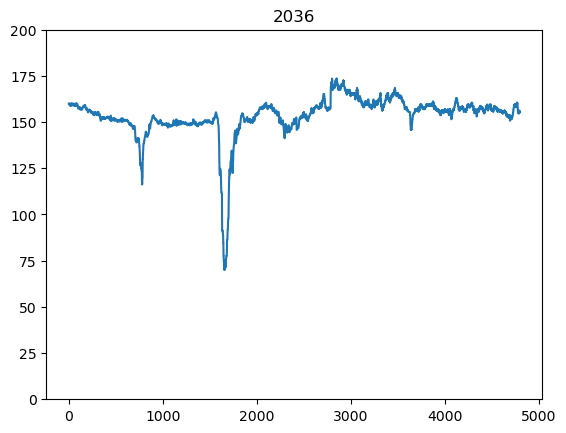

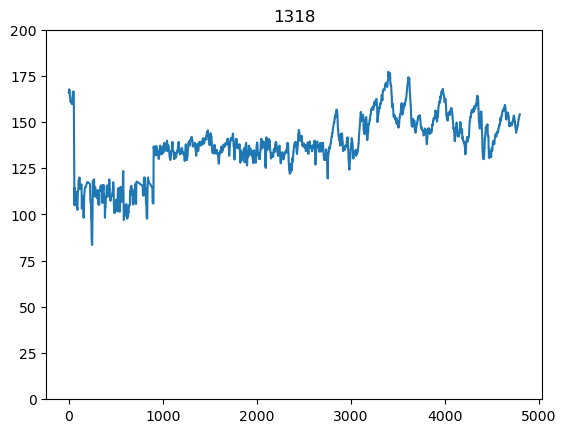

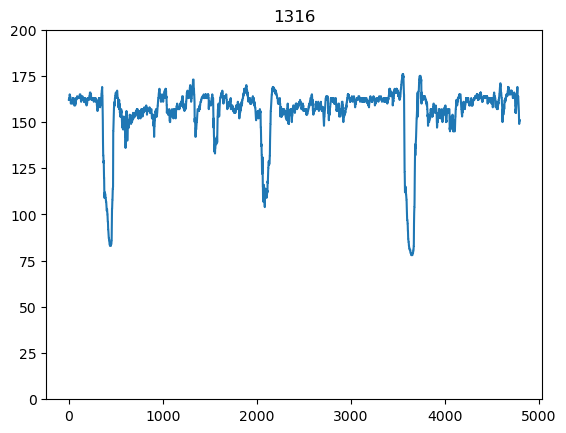

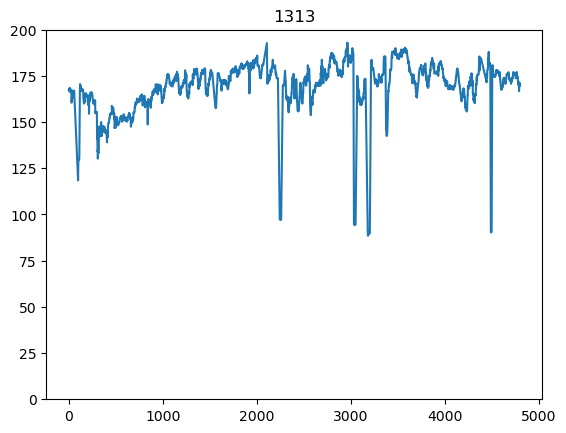

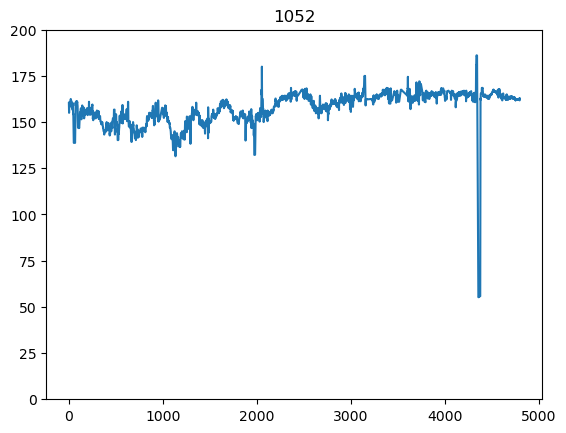

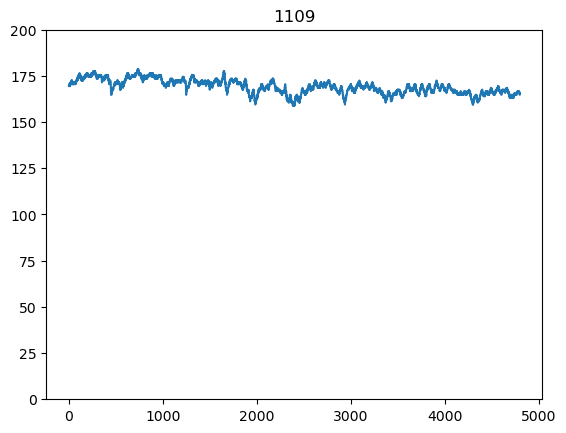

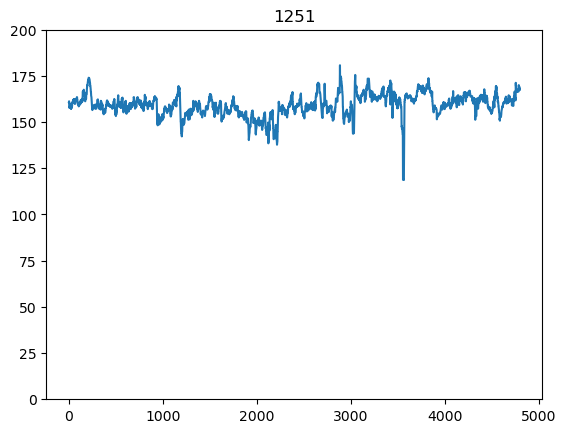

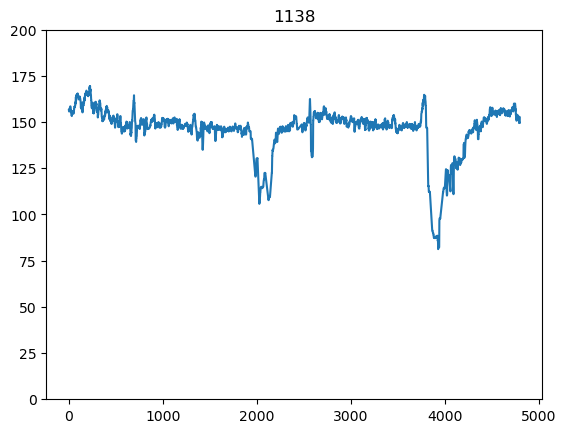

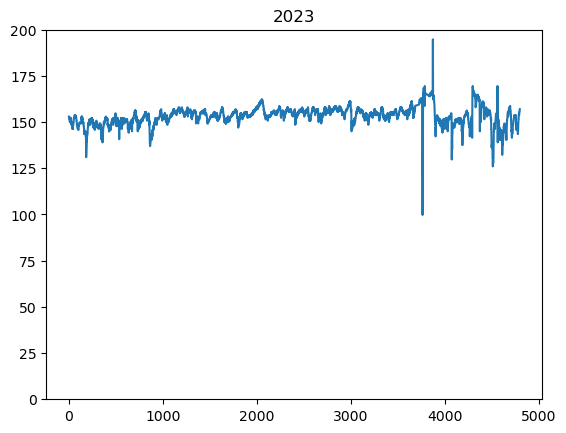

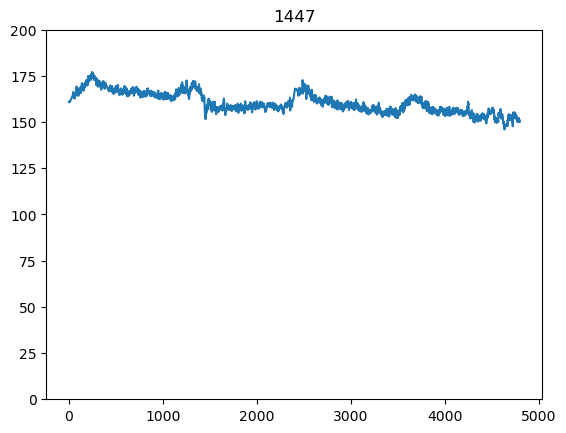

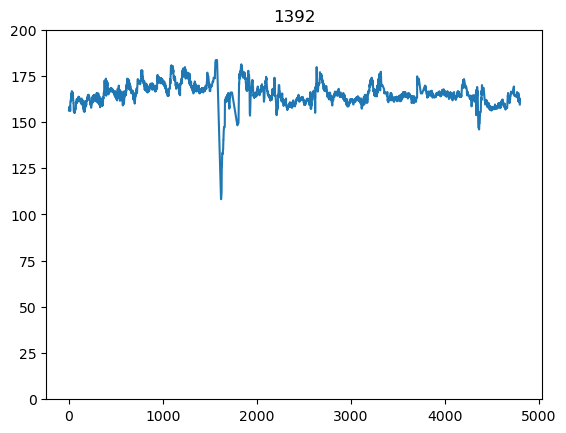

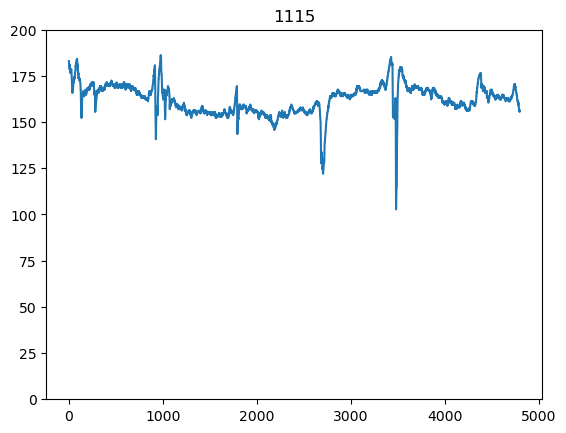

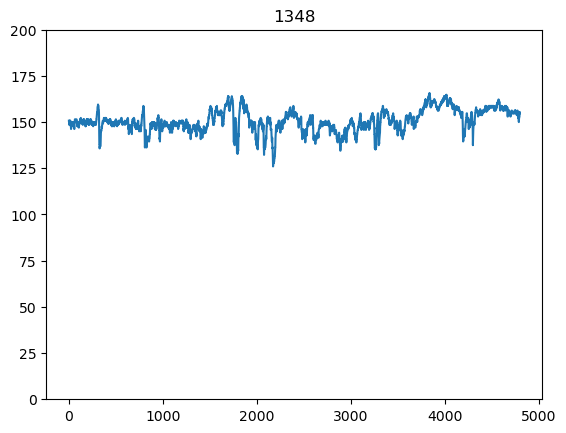

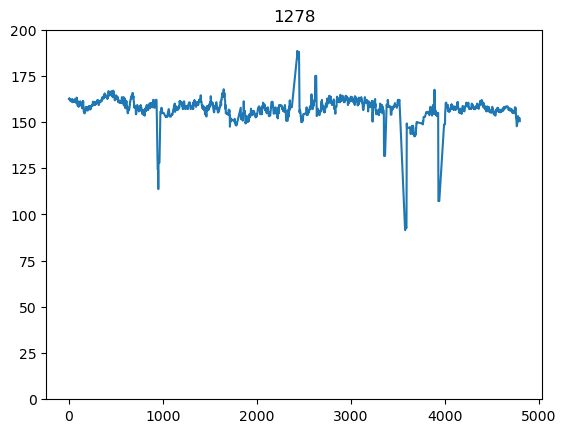

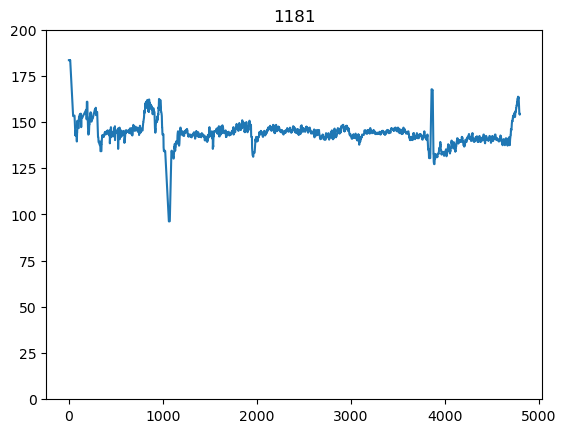

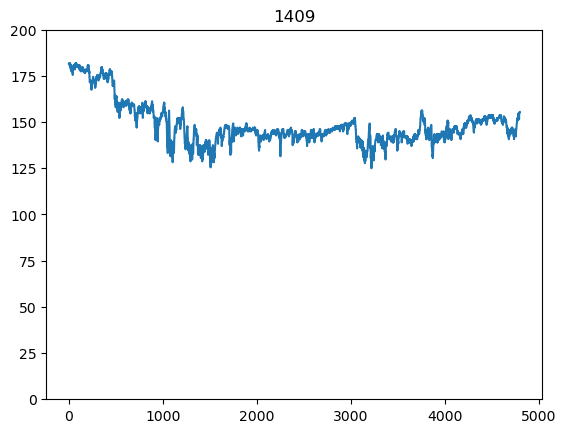

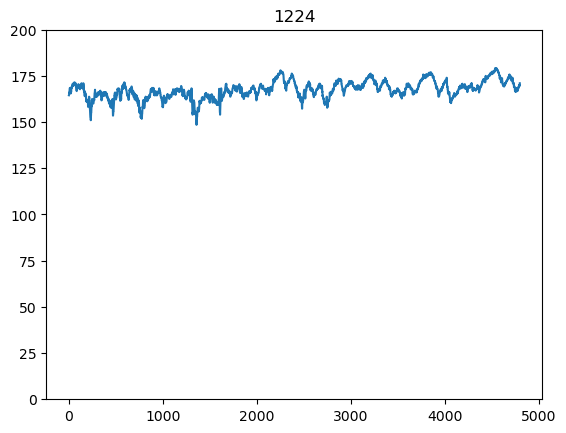

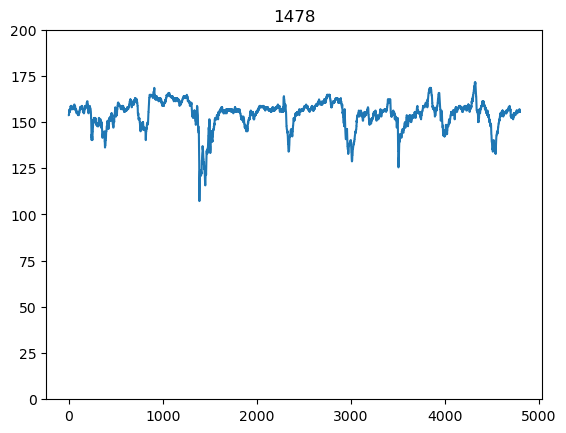

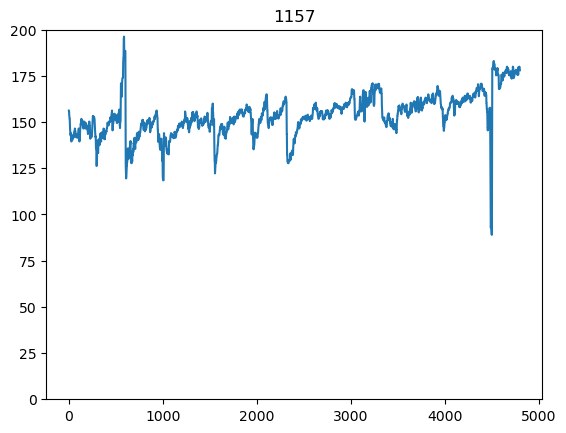

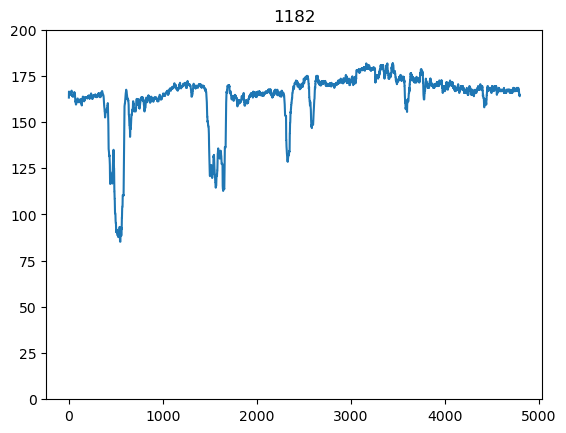

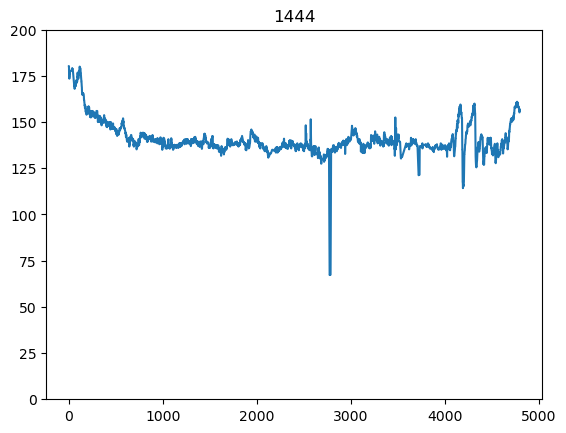

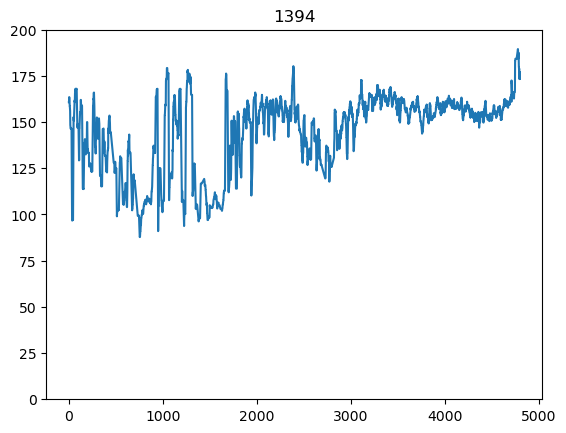

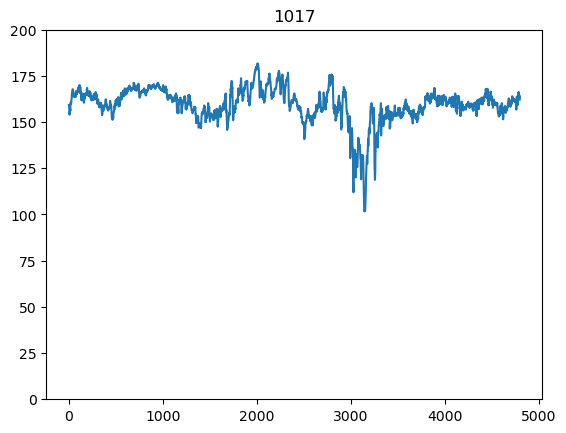

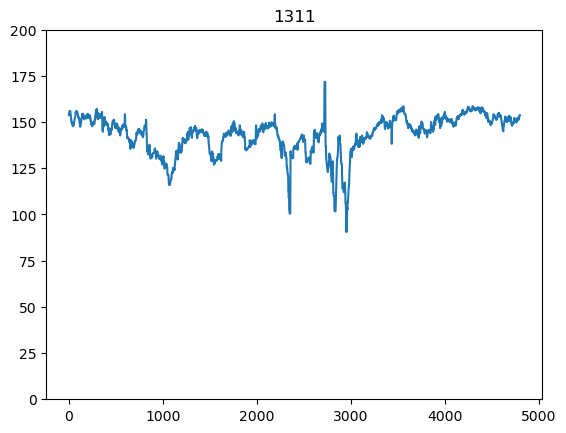

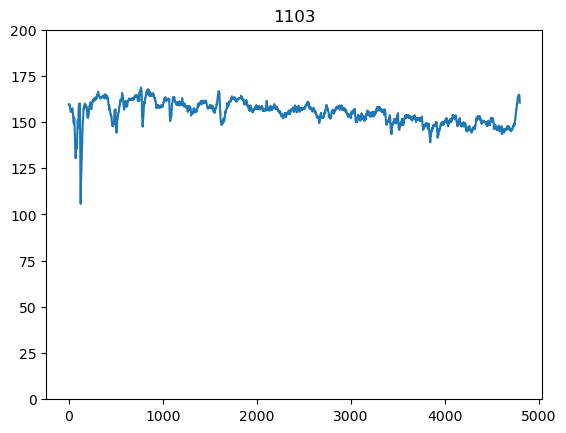

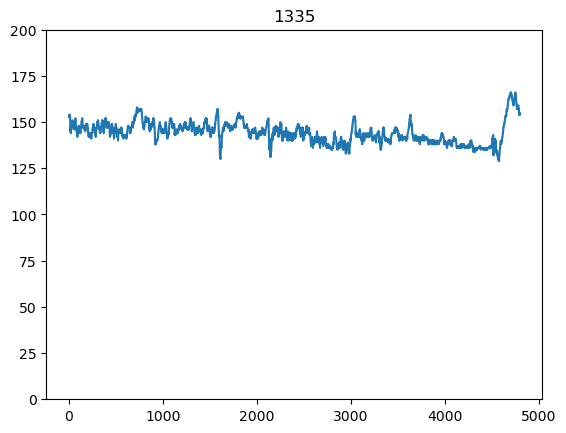

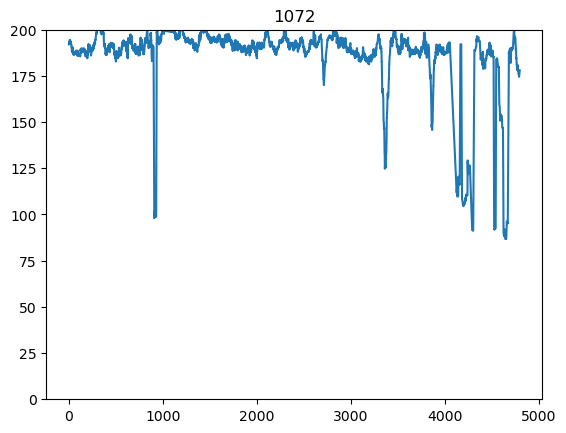

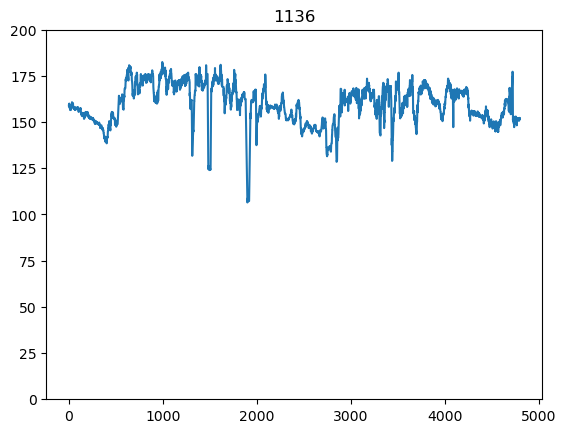

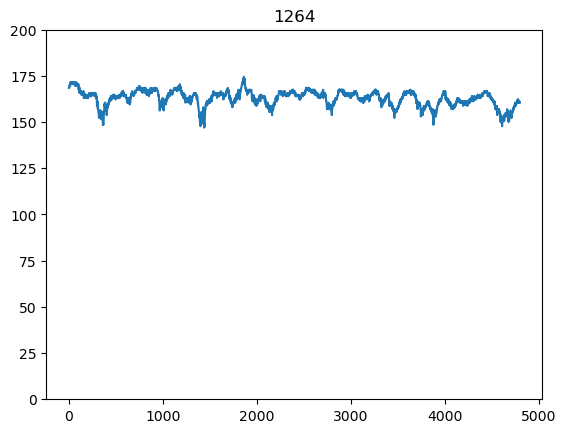

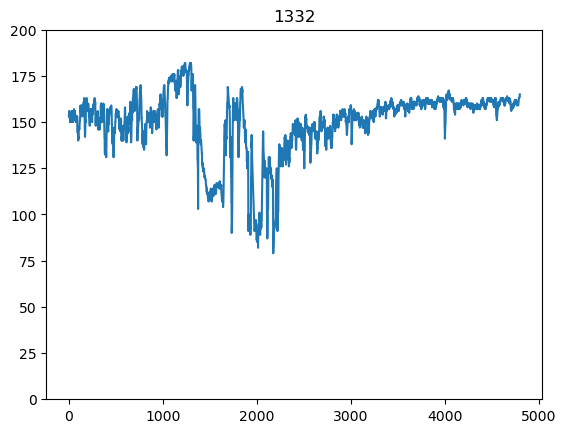

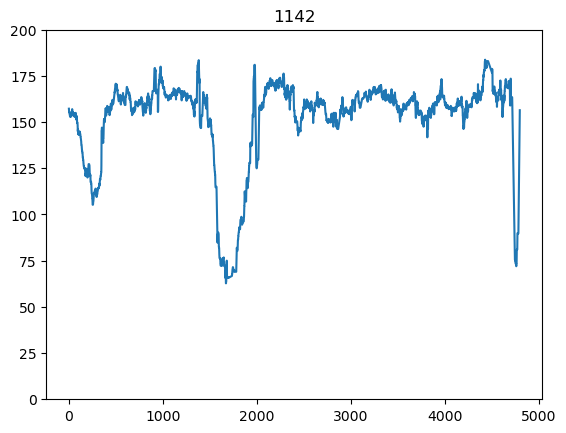

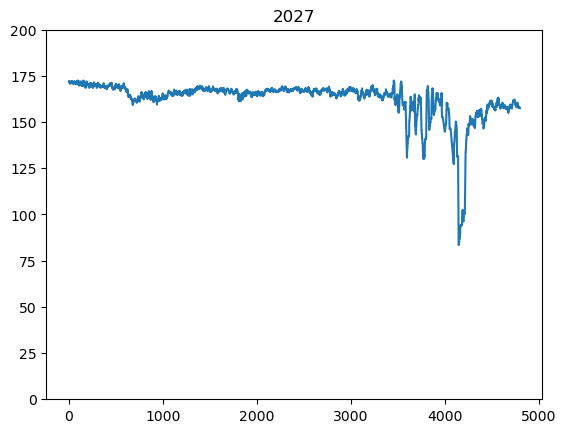

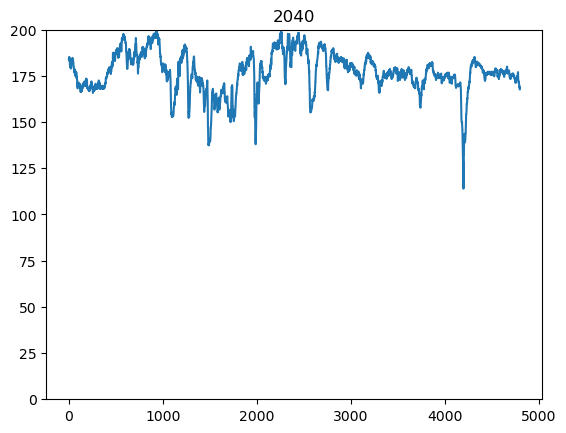

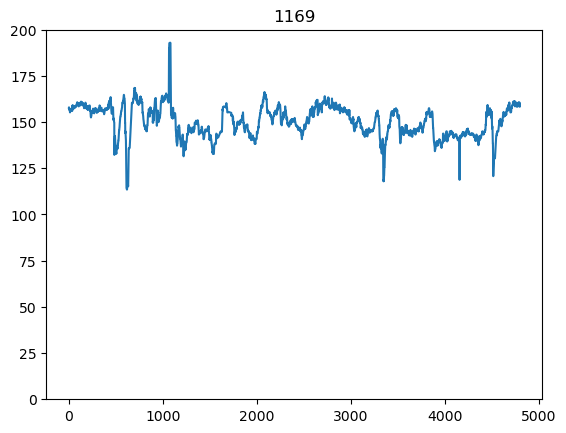

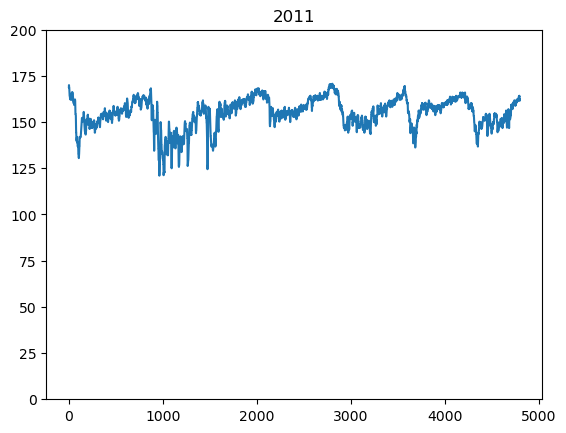

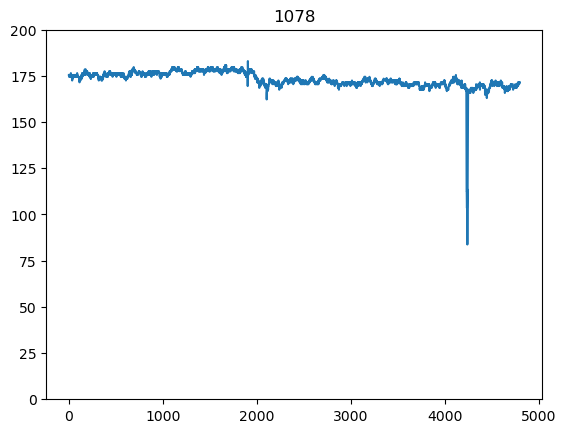

KeyError: 0

In [41]:
for key, value in fhr_first.items():
    if value[0] >= 150:
        if value.iloc[-1] >= 150:
            plt.plot(value)
            plt.ylim(0, 200)
            plt.title(key)
            plt.show()